<a href="https://colab.research.google.com/github/99sbr/NLP/blob/main/TSDAE%20-Job2vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -U sentence-transformers
!pip install faiss-gpu
!pip install spacy
!python -m spacy download en_core_web_lg
!pip install -U contextualized_topic_models

     |████████████████████████████████| 79 kB 5.9 MB/s 
     |████████████████████████████████| 4.0 MB 30.7 MB/s 
     |████████████████████████████████| 1.2 MB 40.4 MB/s 
     |████████████████████████████████| 77 kB 6.7 MB/s 
     |████████████████████████████████| 6.5 MB 47.9 MB/s 
     |████████████████████████████████| 895 kB 42.6 MB/s 
     |████████████████████████████████| 596 kB 45.8 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=c4187b12228aa6f12e46b932b02cbce111811f5839b03f04202a2afa9e4b7f5e
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 85.5 MB 95 kB/s 
     |████████████████████████████████| 827.9 MB 1.3 MB/s 
  Cr

In [1]:
!nvidia-smi 

Sat Apr  9 09:49:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [4]:
jobs_df = pd.read_csv('/content/job_postings.csv')
jobs_df = jobs_df[['title','department','requirements']]
jobs_df.dropna(subset=['title','department','requirements'],inplace=True)
filtered_dept = jobs_df.department.value_counts()[:50].index.tolist()
jobs_df = jobs_df[jobs_df.department.isin(filtered_dept)]

In [5]:
import spacy
from gensim import models, corpora
from nltk.corpus import stopwords
nlp = spacy.load('en', disable=['parser', 'ner'])
stop_words = stopwords.words('english')

In [6]:
import re

def clean_up(text):
    removal = ['ADV', 'PRON', 'CCONJ', 'PUNCT', 'PART', 'DET', 'ADP', 'SPACE']
    text_out = []
    doc = nlp(text)
    for token in doc:
        if token.is_stop == False and token.is_alpha and len(token) > 2 and token.pos_ not in removal:
            lemma = token.lemma_
            text_out.append(lemma)
    return text_out

clean_requirements = jobs_df.requirements.apply(lambda x: clean_up(x))
jobs_df_cleaned = jobs_df.copy(deep=True)
jobs_df_cleaned['clean_requirements'] = [" ".join(x) for x in clean_requirements]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


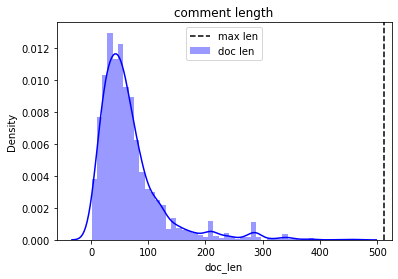

In [7]:
jobs_df_cleaned['doc_len'] = jobs_df_cleaned['clean_requirements'].apply(lambda words: len(words.split(" ")))
max_seq_len = 512
sns.distplot(jobs_df_cleaned['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('comment length'); plt.legend()
plt.show()


In [8]:
from sentence_transformers import SentenceTransformer, LoggingHandler
from sentence_transformers import models, util, datasets, evaluation, losses
from torch.utils.data import DataLoader

# Define your sentence transformer model using CLS pooling
model_name = 'bert-base-uncased'
word_embedding_model = models.Transformer(model_name)
pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension(), 'cls')
model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
# Define a list with sentences (1k - 100k sentences)
train_sentences = jobs_df_cleaned['clean_requirements'].values.tolist()
# Create the special denoising dataset that adds noise on-the-fly
train_dataset = datasets.DenoisingAutoEncoderDataset(train_sentences)

# DataLoader to batch your data
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=False)

In [10]:


# Use the denoising auto-encoder loss
train_loss = losses.DenoisingAutoEncoderLoss(model, decoder_name_or_path=model_name, tie_encoder_decoder=True)

# Call the fit method
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=5,
    weight_decay=0,
    scheduler='constantlr',
    optimizer_params={'lr': 3e-5},
    show_progress_bar=True
)

When tie_encoder_decoder=True, the decoder_name_or_path will be invalid.
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertLMHeadModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertLMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertLMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertLMHeadModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.encoder.layer.7.crossattention.self.key.weight', 'bert.encoder.layer.7.crossattention.self.value.weight', 'bert.encoder.layer.4.crossattention.self.query.weight

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/802 [00:00<?, ?it/s]

Iteration:   0%|          | 0/802 [00:00<?, ?it/s]

Iteration:   0%|          | 0/802 [00:00<?, ?it/s]

Iteration:   0%|          | 0/802 [00:00<?, ?it/s]

Iteration:   0%|          | 0/802 [00:00<?, ?it/s]

In [11]:
model.save('/content/TSDAE-model')

In [12]:
train_sentences_encodings = model.encode(train_sentences)

In [13]:
import faiss
encoded_data = np.asarray(train_sentences_encodings.astype('float32'))
index = faiss.IndexIDMap(faiss.IndexFlatIP(768))
index.add_with_ids(train_sentences_encodings, np.array(range(0, len(jobs_df_cleaned))))
faiss.write_index(index, 'train_sentences_encodings.index')

In [14]:
def fetch_job_info(dataframe_idx):
    info = jobs_df_cleaned.iloc[dataframe_idx]
    meta_dict = {}
    meta_dict['Title'] = info['title']
    meta_dict['department'] = info['department']
    meta_dict['requirements'] = info['clean_requirements']
    return meta_dict
    
def search(query, top_k, index, model):
    query_vector = model.encode([query])
    top_k = index.search(query_vector, top_k)
    top_k_ids = top_k[1].tolist()[0]
    top_k_ids = list(np.unique(top_k_ids))
    results =  [fetch_job_info(idx) for idx in top_k_ids]
    return results

In [15]:
from pprint import pprint

job ="Web Developer"

results=search(jobs_df_cleaned[jobs_df_cleaned.title==job]['clean_requirements'].values[0], top_k=5, index=index, model=model)

print("\n")
for result in results:
    print('\t',result)



	 {'Title': 'Web Developer', 'department': 'Engineering', 'requirements': 'experience LikeWeb Services restful interface designclient mvc framework Backbone Spine KnockoutSingle Page Architecture experienceCoffeeScriptGitYour QualificationsFour year college degree Computer Science CIS Computer EngineeringProfessional experience JavaScriptExperience JavaScript framework jQuery Prototype MooTools ZeptoUnderstanding MVC design patternsexperience single page web applicationsexperience client html templatingstrong problem solve skillscomfortable cut edge technologyunrelenting desire deliver high quality product'}
	 {'Title': 'Front End Developer', 'department': 'R&D', 'requirements': 'year experience web developmentpassionate web design web technologyexcellent MVC MVVM Framework AngularJS Backbone Ember Knockout JavaScript librariesexperience mvc equivalent server developmentgood understanding Client development architecture good practice design patternsA sense curiosity hand character te

In [16]:
job ="Data Scientist"

results=search(jobs_df_cleaned[jobs_df_cleaned.title==job]['clean_requirements'].values[0], top_k=5, index=index, model=model)

print("\n")
for result in results:
    print('\t',result)



	 {'Title': 'Product Analyst', 'department': 'Engineering', 'requirements': 'experience write SQL query professional settingexperience work big dataexcellent knowledge iOS numerical academic background mathematic economic statistic computer produce report high level quality detailan appreciation statistical significance mean statistical modelsconfident communicate result analysisbonus programming experience Java Objective JavaScript PythonBonus experience work mobile analytic product'}
	 {'Title': 'Data Scientist', 'department': 'Engineering', 'requirements': 'hand experience data analyst work large data set graduate degree quantitative field Mathematics Economics Engineering Operations Research Computer Science related field strong quantitative logical problem solve skill experience work datum scientist multiple discipline Machine Learning Applied Math Statistics Optimization Economics ability partner open minded exchange idea function prove ability build support complex logic algor